In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

# General idea

目标: 预测一个用户下个月是否会买某样商品(S1), 以及买的具体日期(S2)

S1: 类似Indicator方程, 买了才计分, 最后处于所有用户数.

S2: 计算购买的真是日期和预测日期之间的差.

1. 用户是抽样的，用户所有行为给的全量数据。不浏览直接下单的入口有很多，望选手自己理解把握。
    -> 是否需要构造直接下单的feature?

2. 随机抽样看一下用户的行为数据.
    -> 需要提升下数据的质量, missing value和outlier的处理.

## scripts
1. 更早之前的数据肯定对现在的预测影响会更小，所以会有个权重的问题.
    
    也就是你得到了十个模型，最接近预测日的算model_0，最远的算model_9，那么给model_0权重0.7，给model_9的权重0.05

1. 均值特征:
2. 活跃度特征:
3. 统计特征:

In [9]:
FILE_jdata_sku_basic_info='../data/jdata_sku_basic_info.csv'
FILE_jdata_user_action='../data/jdata_user_action.csv'
FILE_jdata_user_basic_info='../data/jdata_user_basic_info.csv'
FILE_jdata_user_comment_score='../data/jdata_user_comment_score.csv'
FILE_jdata_user_order='../data/jdata_user_order.csv'

# SKU基本信息表
#### 可以理解为商品信息表

In [11]:
sku_info = pd.read_csv(FILE_jdata_sku_basic_info)
sku_info.columns

Index(['sku_id', 'price', 'cate', 'para_1', 'para_2', 'para_3'], dtype='object')

In [13]:
sku_info.describe()

,sku_id,price,cate,para_1,para_2,para_3
count,99412.000000,9.941200e+04,99412.000000,99412.000000,99412.000000,99412.000000
mean,49706.500000,1.404066e+03,71.675331,187.836283,-0.070595,-0.117119
std,28697.916818,2.480563e+04,28.310322,4139.406198,1.696164,1.878670
min,1.000000,4.300000e+00,1.000000,0.080000,-1.000000,-1.000000
25%,24853.750000,2.732000e+02,71.000000,40.580000,-1.000000,-1.000000
50%,49706.500000,5.956500e+02,71.000000,74.090000,-1.000000,-1.000000
75%,74559.250000,1.185000e+03,101.000000,104.872500,-1.000000,-1.000000
max,99412.000000,3.880033e+06,101.000000,475292.880000,6.000000,7.000000


In [17]:
sku_info.head()

,sku_id,price,cate,para_1,para_2,para_3
0,1,364.2,71,247.95,-1,-1
1,2,36.7,46,6.40,-1,-1
2,3,953.3,71,178.92,-1,-1
3,4,110.6,83,6366.88,-1,-1
4,5,241.5,71,31.74,-1,-1


### 商品类别分析

[ 71  46  83 101   1  30]


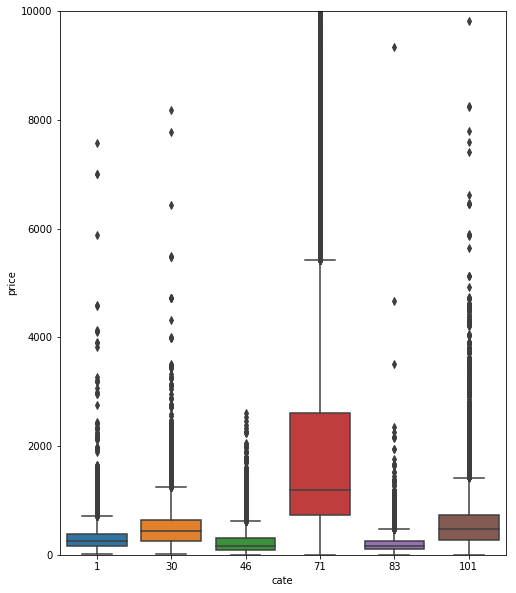

In [29]:
var = 'cate'
# 查看有多少cate
print(sku_info[var].unique())
data = pd.concat([sku_info['price'], sku_info[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 10))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=10000);

从价格的箱线图, 可以看出需要预测31和101的相关品种，**71有些特殊,后续需要关注.**

而1和101的分布很类似, 其次和30也有些相似. 不过outlier的分布上1和30会比较相似. 

姑且假设:
    1. 30和101几乎是相似的商品, 价格差不多,但是101存在一些比较高的价格.
    2. 46,83和1属于低一档的商品.83是最低.

### 产品规格

,price,para_1
price,1.000000,0.000418
para_1,0.000418,1.000000


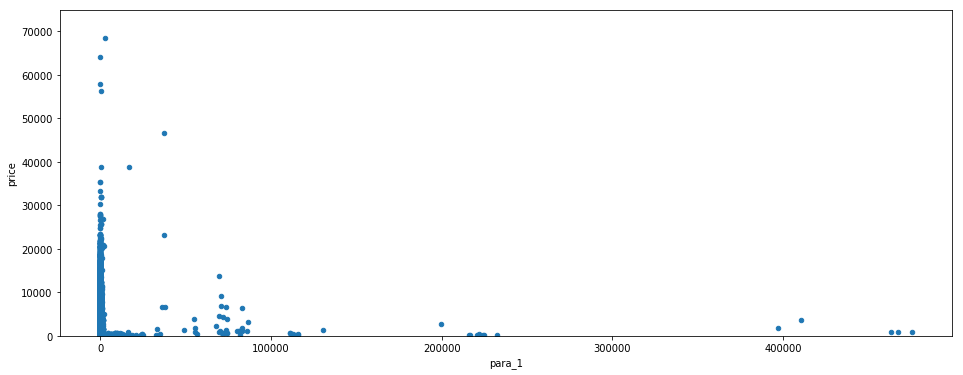

In [54]:
var = 'para_1'
data = pd.concat([sku_info['price'], sku_info[var]], axis=1)
data.plot.scatter(x=var, y='price', figsize=(16, 6), ylim=(0,75000));
data.corr()

[-1  3  2  4  6  1  5]


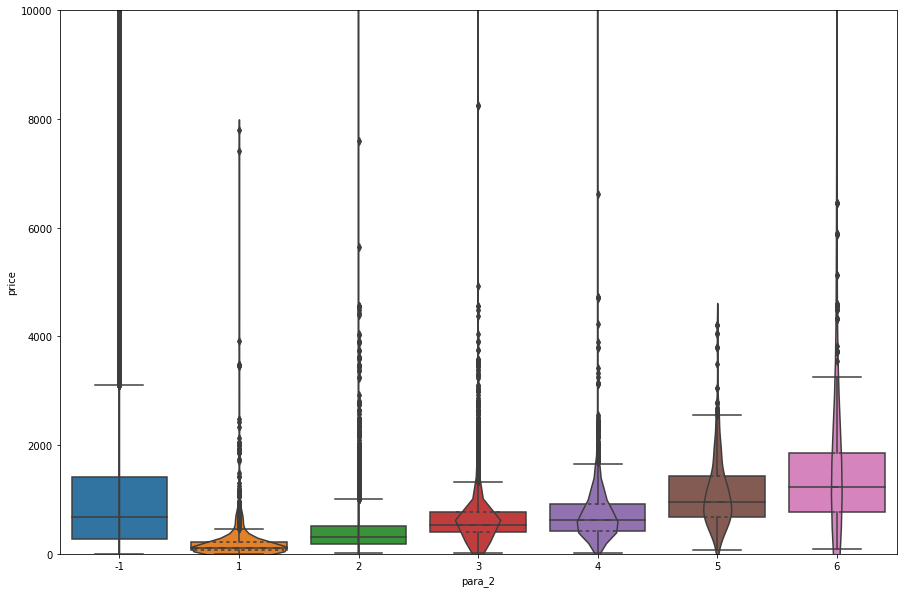

In [61]:
var = 'para_2'
print(sku_info[var].unique())
data = pd.concat([sku_info['price'], sku_info[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.violinplot(x=var, y="price", data=data,split=True,inner="quart")
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=10000);

[-1  5  2  4  3  7  6  1]
              price        para_3
count  9.941200e+04  99412.000000
mean   1.404066e+03     -0.117119
std    2.480563e+04      1.878670
min    4.300000e+00     -1.000000
25%    2.732000e+02     -1.000000
50%    5.956500e+02     -1.000000
75%    1.185000e+03     -1.000000
max    3.880033e+06      7.000000


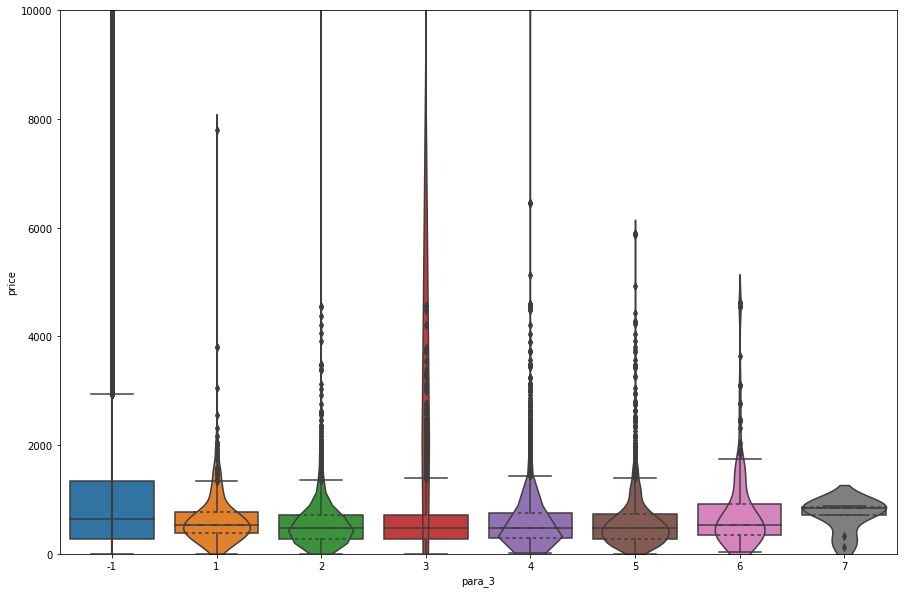

In [64]:
var = 'para_3'
print(sku_info[var].unique())
data = pd.concat([sku_info['price'], sku_info[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.violinplot(x=var, y="price", data=data,split=True,inner="quart")
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=10000);

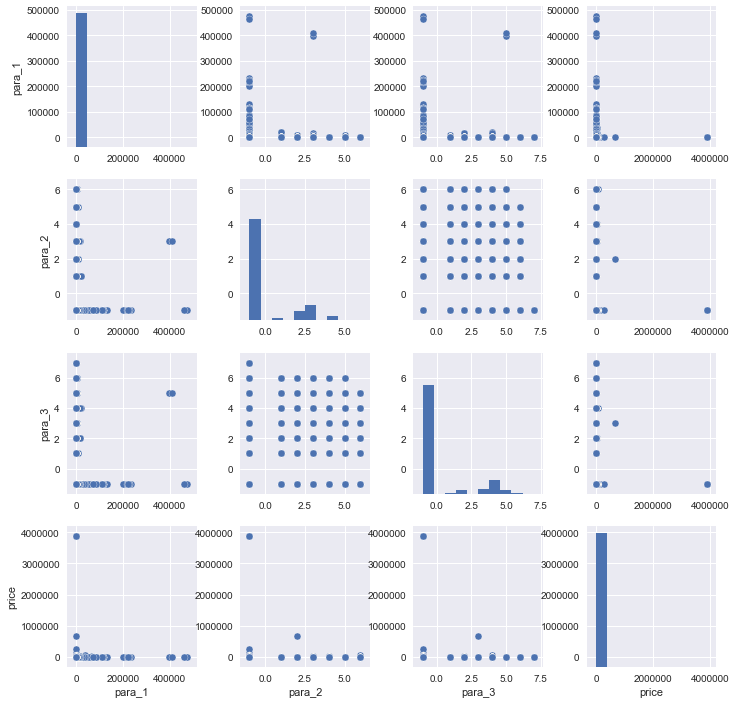

In [66]:
#scatterplot
sns.set()
cols = ['para_1', 'para_2', 'para_3', 'price']
sns.pairplot(sku_info[cols], size = 2.5)
plt.show();

看上去这几个商品参数可以分成几类:
    1. 无关的para_1: 基本不相关.猜测是一种不是很关键的参数, 就像衣服的尺码一样, 不会因为你的尺码而价格变化.
    2. 相关的para_2: 随着级别的升高价格也随之上升.应该是一个商品关键参数, 类似于商品的品级, 越大越贵.
    3. 弱相关的para_3: 和类别有一些相关, 仅限于一些outlier的分布,隐约可以看出outlier有一些高斯分布的.
        7这个参数有些奇怪算是竟然出现反向的outlier.值得关注.这个其实应该更加像衣服的尺码, 7可以用超大码解释, 可能超大码会更加贵一些.

总结: 峰值价格呈现一个随着para_2,3的正态分布.

## Missing data

In [79]:
#missing data
total = sku_info[sku_info==-1 ].sum().abs().sort_values(ascending=False)
percent = (sku_info[sku_info ==-1 ].sum().abs()/sku_info.count().abs()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
para_3,80537.0,0.810134
para_2,75026.0,0.754698
para_1,0.0,0.000000
cate,0.0,0.000000
price,0.0,0.000000
sku_id,0.0,0.000000


可以看到有非常多的para_3和2缺失了,后续训练时需要对他们进行处理.
 
直观上对于预测是否会购买我觉得不太重要, 我们或许可以假设多余50%以上的缺失值或许是因为这个属性本身就不太重要?

继续用衣服的假设, 或许衣服本身就写着一个均码, 那本身统计这个参数就没意义了,只有特小或者特大才会关注这些型号.

所以, 尝试对para列进行one-hot编码, 如果效果不好就drop相应列.